In [1]:
# !pip install scikit-learn==0.22

In [2]:
import configparser
import ast
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from pycaret.datasets import get_data 
from pycaret.classification import *
import copy
import os
import requests
from auto_learning_utility import *
import mlflow
from mosaicml import *
from mosaicml.constants import MLModelFlavours
# from plots import roc_confusion_matrix_plot, feature_imp_plot
# from db_connection import connection_string,db_engine
from pycaret.internal.tabular import _calculate_metrics_supervised

In [3]:
# !pip install xlrd==1.1.0

In [4]:
config = configparser.ConfigParser()
config.read('/notebooks/notebooks/code/config_autolearning.ini')

['/notebooks/notebooks/code/config_autolearning.ini']

In [5]:
# base_path = config.get('BASE_PATH','base_path')

In [6]:
feedback_data = config.get('FEEDBACK_DATA','feedback_data')
# df = pd.read_excel(os.path.join(base_path, feedback_data))

In [7]:
df = pd.read_excel(feedback_data)

In [8]:
train_y_column = ast.literal_eval(config.get("COLUMNS", "train_y_column"))
config.set('COLUMNS', 'train_x_column_list', str(df.drop(train_y_column,axis=1).columns.to_list())) ##whatever list we can enter here
with open('config.ini', 'w') as configfile:
    config.write(configfile)
train_x_column_list = ast.literal_eval(config.get("COLUMNS", "train_x_column_list"))
ai = config.get('LEARNING_TYPE','ai')
save_model_path = config.get('SAVE_MODEL_PATH','save_model_path')

In [9]:
if ai == 'base_ai':
    df = pd.DataFrame(columns = df.columns.to_list(),index=[0])
    df.iloc[0] = 0
    df.ci_distance.iloc[0] = 99
    df = df.astype('int')
else:
    df = pd.read_excel(feedback_data)
#     df = pd.read_excel(os.path.join(base_path, feedback_data))

In [10]:
train_columns = ['ci_distance',
       'time_diff', 'time_diff_s', 'application_service', 'u_business_service',
       'service_comp', 'domain_comp', 'data_center_comp', 'ci_similarity',
       'cr_comp', 'ci_pred', 'alert_pred', 'weighted_proba', 'kb']

In [11]:
total_columns = copy.deepcopy(train_columns)
total_columns.append(train_y_column)

# 1. Setup dataset

In [12]:
#categorical_features_name = ['ci_distance','application_service','u_business_service','cr_comp']

In [13]:
df= df[df.time_diff <= 15].reset_index().drop(columns='index')

In [14]:
## this need to be added in config
num_col = ['ci_distance', 'time_diff', 'time_diff_s','ci_similarity','ci_pred', 'alert_pred', 'weighted_proba']
cat_col = ['application_service','u_business_service', 'service_comp', 'domain_comp', 'data_center_comp', 'cr_comp','kb']

In [15]:
exp_name='ns3_hybrid_model'

In [16]:
clf1 = setup(data = df[total_columns],numeric_features = num_col,categorical_features=cat_col, target = train_y_column, log_experiment=False, experiment_name=exp_name,silent=True,preprocess=False)

,Description,Value
0,session_id,6089
1,Target,Actual (Validated)
2,Target Type,Binary
3,Label Encoded,"correlated: 0, non-correlated: 1"
4,Original Data,"(210, 15)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,7
8,Transformed Train Set,"(146, 14)"
9,Transformed Test Set,"(64, 14)"


# 2. Create Model

In [17]:
# #rf = create_model('rf',X_train_data=train_X,y_train_data=train_y)
#rf = create_model('rf')

In [18]:
#best = compare_models(include=['ada', 'et', 'gbc', 'rf','lr'],sort='AUC')
best = compare_models(include=['et','rf','lr'],sort='Prec.')
best_model_name = pull()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9590,0.9942,0.9659,0.9826,0.9739,0.8789,0.8817,0.3540
et,Extra Trees Classifier,0.9457,0.9831,0.9659,0.9672,0.9659,0.8313,0.8386,0.4690
lr,Logistic Regression,0.9243,0.9597,0.9667,0.9436,0.9532,0.7460,0.7652,0.0160


In [19]:
best_model_name = {k: v for k, v in best_model_name.iloc[0,0:1].items()}

In [20]:
# tune hyperparameters with custom_grid
params = {"max_depth": np.random.randint(1, (len(df[train_columns].columns)*.85),20),
         "max_features": ["auto"],
          "min_samples_leaf": [1,2,3,4,5,6], #remove 1 after more data
          "max_leaf_nodes" : [None],
          "max_samples" : [None],
          "min_impurity_decrease": [0.0], 
          "min_impurity_split": [None],
          "min_samples_split":[2,4,6],
          "n_estimators":[100],      
          "criterion": ["gini", "entropy"]}

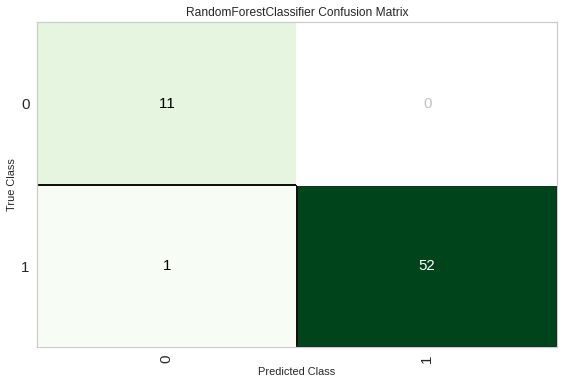

In [21]:
plot_model(best, plot = 'confusion_matrix')

# 3. Tune Hyperparameters

In [22]:
tuned_best_model = tune_model(best,optimize='Prec.')
#tuned_best_model = tune_model(best_model,optimize='Prec.',custom_grid=params)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9333,0.9583,0.9167,1.0000,0.9565,0.8148,0.8292
1,0.9333,0.9583,0.9167,1.0000,0.9565,0.8148,0.8292
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,0.8667,0.9167,0.8333,1.0000,0.9091,0.6667,0.7071
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,0.9286,0.9697,0.9091,1.0000,0.9524,0.8108,0.8257
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
9,0.9286,0.9375,0.9167,1.0000,0.9565,0.7586,0.7817


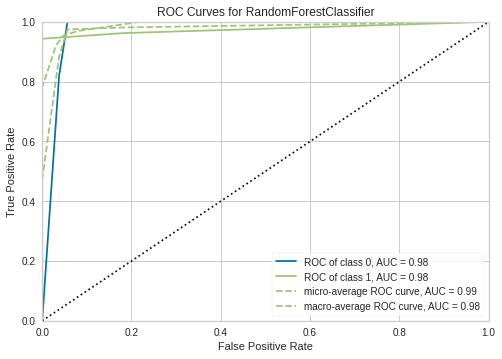

In [23]:
# plotting a model
plot_model(tuned_best_model)

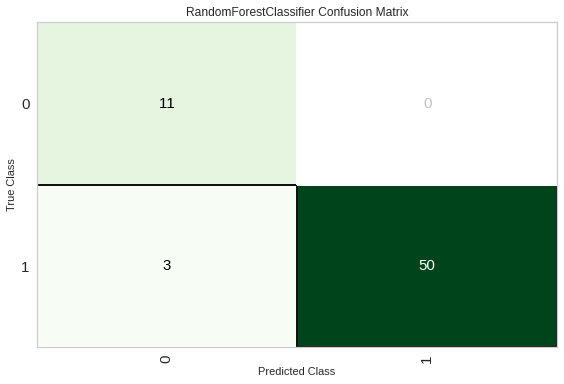

In [24]:
plot_model(tuned_best_model, plot = 'confusion_matrix')

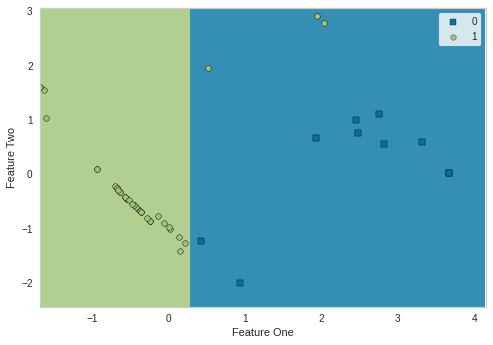

In [25]:
plot_model(tuned_best_model, plot = 'boundary')

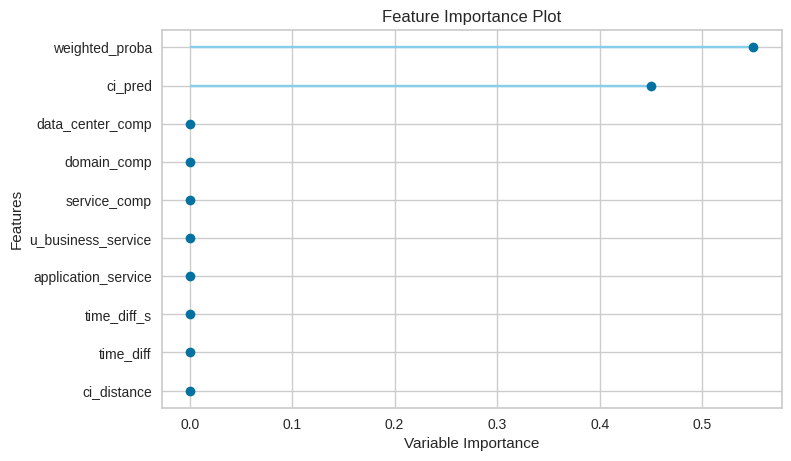

In [26]:
plot_model(tuned_best_model, plot = 'feature')

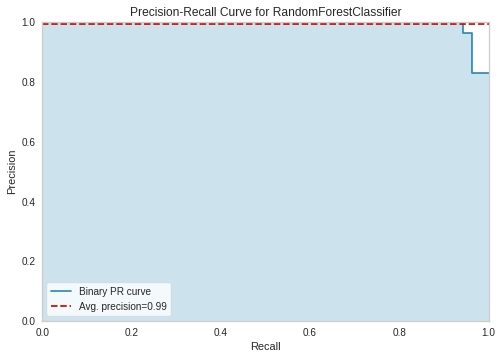

In [27]:
plot_model(tuned_best_model, plot = 'pr')

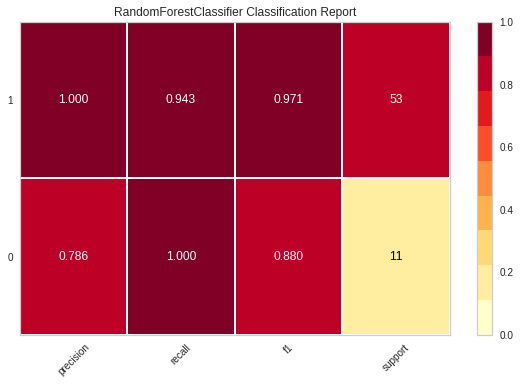

In [28]:
plot_model(tuned_best_model, plot = 'class_report',)

# 4. Interpret Model

In [29]:
# !pip install shap

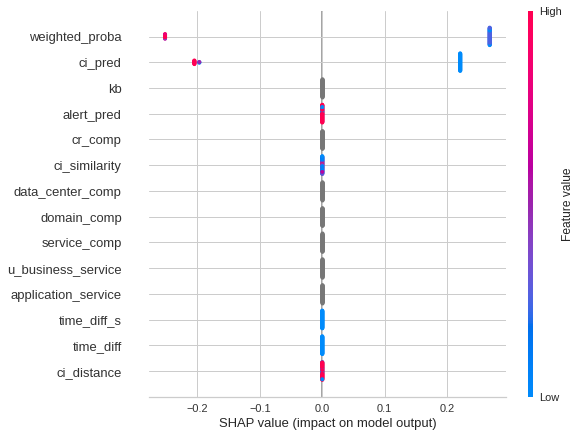

In [30]:
if best_model_name['Model'] in ['Logistic Regression','Ada Boost Classifier','Gradient Boosting Classifier']:
    print('This function only supports tree based models for binary classification: xgboost, catboost, dt, lightgbm, et, rf.')
else:
    interpret_model(tuned_best_model)

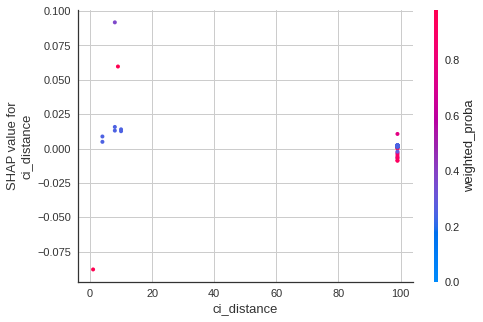

In [31]:
if best_model_name['Model'] in ['Logistic Regression','Ada Boost Classifier','Gradient Boosting Classifier']:
    print('This function only supports tree based models for binary classification: xgboost, catboost, dt, lightgbm, et, rf.')
else:
    interpret_model(best, plot = 'correlation')

In [32]:
if best_model_name['Model'] in ['Logistic Regression','Ada Boost Classifier','Gradient Boosting Classifier']:
    print('This function only supports tree based models for binary classification: xgboost, catboost, dt, lightgbm, et, rf.')
else:
    interpret_model(best, plot = 'reason', observation = 21)

# 5. Test Model

In [33]:
tuned_best_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1, max_features=1.0,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.002, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=120,
                       n_jobs=-1, oob_score=False, random_state=6089, verbose=0,
                       warm_start=False)

In [34]:
predictions = predict_model(tuned_best_model)
predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9531,0.9760,0.9434,1.0000,0.9709,0.8514,0.8610


,ci_distance,time_diff,time_diff_s,application_service,u_business_service,service_comp,domain_comp,data_center_comp,ci_similarity,cr_comp,ci_pred,alert_pred,weighted_proba,kb,Actual (Validated),Label,Score
0,99.0,0.0,0.0,0,0,0,0,0,0.116,0,0.0,1.0,0.25,0,non-correlated,non-correlated,1.0
1,99.0,0.0,0.0,0,0,0,0,0,0.200,0,0.0,1.0,0.25,0,non-correlated,non-correlated,1.0
2,99.0,0.0,0.0,0,0,0,0,0,0.236,0,0.0,1.0,0.25,0,non-correlated,non-correlated,1.0
3,10.0,0.0,0.0,0,0,0,0,0,0.180,0,0.0,1.0,0.25,0,non-correlated,non-correlated,1.0
4,99.0,0.0,0.0,0,0,0,0,0,0.216,0,0.0,1.0,0.25,0,non-correlated,non-correlated,1.0


In [35]:
## Save this in database with timestamp and show on UI
results = pull()

# 6. Finalize model

In [36]:
finalize_model(tuned_best_model)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1, max_features=1.0,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.002, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=120,
                       n_jobs=-1, oob_score=False, random_state=6089, verbose=0,
                       warm_start=False)

In [37]:
final_model = finalize_model(tuned_best_model)

In [38]:
## because of this model explainability will not work
#plot_model(final_model, plot='calibration')
#calibrated_model = calibrate_model(final_model, method = 'isotonic')
#plot_model(calibrated_model, plot='calibration')

In [39]:
hybrid_model = RuleAugmentedEstimator(final_model,[ai])

In [40]:
#train_columns = ['ci_distance', 'kb', 'application_service', 'time_diff', 'u_business_service', 'time_diff_s', 'cr_comp', 'ci_similarity', 'weighted_proba']
# train_X = df[train_columns]
# train_y = df[train_y_column].values

In [41]:
hybrid_model.fit(df[train_columns], df[train_y_column].values)

In [42]:
predictions = hybrid_model.predict(df[train_columns])
#predictions_proba = final_model.predict_proba(df,trained_columns=train_columns)
# x = train_X.copy()
# x['predicted'] = predictions
# x['actual'] = df['final_class_of_prediction']

# 7. Register Model

In [43]:
@scoring_func
def score(model, payload):
#     payload = request.json["payload"]
    payload = payload["payload"]
    data = pd.DataFrame(eval(payload))
    result= model.predict(data)
#     result = 1- result[:,0]
#     result = np.float64(result)
    result = result.tolist()
    return result

In [44]:
# tenant_id = os.getenv('tenant_id')
tenant_id = 'python_3_7_test1_new1'
model_name = 'Hybrid_Model' + "_" + str(tenant_id)

In [45]:
register_model_output = register_model(hybrid_model, score, name=model_name, 
                description="Predict correlation",
                flavour=MLModelFlavours.sklearn, pretty_output=False)

In [46]:
register_model_output['versions'] = sorted(register_model_output['versions'], key=lambda x : x['created_on'], reverse=True)
register_model_output_version = register_model_output['versions'][0]['id']

In [47]:
register_model_output_id = register_model_output['id']

In [48]:
hardware_id = 'df2109b5-66fb-4b89-b249-5d1731e3e91e'

In [49]:
## deploy model 
model_deploy = deploy_model(register_model_output_id, register_model_output_version, hardware_id)

In [50]:
requests.json = {"payload": df[train_columns].loc[1:3].to_json()}

In [51]:
print(requests.json)

{'payload': '{"ci_distance":{"1":99,"2":99,"3":99},"time_diff":{"1":0,"2":0,"3":0},"time_diff_s":{"1":0,"2":0,"3":0},"application_service":{"1":0,"2":0,"3":0},"u_business_service":{"1":0,"2":0,"3":0},"service_comp":{"1":0,"2":0,"3":0},"domain_comp":{"1":0,"2":0,"3":0},"data_center_comp":{"1":0,"2":0,"3":0},"ci_similarity":{"1":0.228,"2":0.2,"3":0.168},"cr_comp":{"1":0,"2":0,"3":0},"ci_pred":{"1":0.0,"2":0.0,"3":0.0},"alert_pred":{"1":1.0,"2":1.0,"3":1.0},"weighted_proba":{"1":0.25,"2":0.25,"3":0.25},"kb":{"1":0,"2":0,"3":0}}'}


In [52]:
js = requests.json

In [53]:
score(hybrid_model,js)

['non-correlated', 'non-correlated', 'non-correlated']

## 8. Save Artifacts and Metrics

#### 8.1 Save plot artifacts

In [54]:
# ### save plots
# confusion_mat_path= roc_confusion_matrix_plot(estimator=final_model,x_test=get_config('X_test'),y_test=get_config('y_test'),plot_type='confusion_matrix',plot_name='confusion_matrix.jpg')
# roc_path= roc_confusion_matrix_plot(estimator=final_model,x_test=get_config('X_test'),y_test=get_config('y_test'),plot_type='roc_curve',plot_name='roc_curve.jpg')
# #feature_imp_path= feature_imp_plot(estimator=final_model,data=get_config('X_train'),plot_name='feature_importance.jpg')

#### 8.2 save params and metrics

In [55]:
# score_results = {k: v for k, v in results.iloc[0,1:].items()}
# final_params = final_model.get_params()

#### 8.3 build DB connection string & set tracking

In [56]:
# db_uri = connection_string(config_path='config.ini')

In [57]:
# mlflow.set_tracking_uri(db_uri)

#### 8.4 add saving artifact location

In [58]:
# artifact_path= os.path.join(base_path, config.get('MLFLOW','artifacts_location'))
# artifact_string = config.get('MLFLOW','artifact_path_string')
# artifacts_location = artifact_string.format(**dict(base_path=artifact_path))

### 8.5 Run mlflow to store all artifacts with versioning and metrics to DB

In [59]:
# try:
#     mlflow.create_experiment(name=exp_name,artifact_location=artifacts_location)
# except:
#     mlflow.set_experiment(exp_name)

#     with mlflow.start_run():
#         mlflow.sklearn.log_model(sk_model=final_model,
#                                  artifact_path='')
#         mlflow.log_params(final_params)
#         mlflow.log_metrics(score_results)
#         mlflow.log_artifact(confusion_mat_path, artifact_path='plots')
#         mlflow.log_artifact(roc_path, artifact_path='plots')
#         run_id = mlflow.active_run().info.run_id
#         #mlflow.log_artifact(feature_imp_path, artifact_path='plots')
#         mlflow.end_run()

## 9. Model Deployment

#### 9. Register a model if not register or get list of registered model

In [60]:
# stage='Staging'
# client = mlflow.tracking.MlflowClient()
# if not client.list_registered_models():
#     model_uri = os.path.join(artifact_path,run_id,'artifacts')
#     try:
#         client.create_registered_model(name=model_name,description=best_model_name['Model'])
#         model_details = client.create_model_version(name=model_name,run_id=run_id,source=model_uri,description=best_model_name['Model'])
#         client.transition_model_version_stage(name=model_name,stage=stage,version=model_details.version) 
#     except:
#         model_details = client.create_model_version(name=model_name,run_id=run_id,source=model_uri,description=best_model_name['Model'])
#         client.transition_model_version_stage(name=model_name,stage=stage,version=model_details.version) 
#     print("No registered model found, registering model by name: {n}, version no: {v}, stage: {s}".format(n=model_name, v=model_details.version, s=stage))
# else:
#     registered_model_list= client.list_registered_models()
#     print("Total {r} registered models found".format(r=len(registered_model_list)))

#### 9.2 Get registered model details

In [61]:
# ### create a dict of registered model with run id, model path to read model and model description
# reg_details = dict()
# for i in registered_model_list:
#     for v in i.latest_versions:
#         reg_details['run_id'] = v.run_id
#         reg_details['model_path'] = v.source
#         reg_details['model_description'] = v.description

#### 9.3 Get registered model metrics 

In [62]:
# query = "select key,value from mlflow_db_aiops.public.metrics where run_uuid='{}'".format(reg_details['run_id'])
# engine = db_engine(config_path='config.ini')
# metrics_df = pd.read_sql_query(sql=query,con=engine)
# reg_details.update(dict(zip(metrics_df.key,metrics_df.value))) ## update metrics to reg_details dict

#### 9.4 Load registered model and test on new test data 

In [63]:
# reg_model_ = pd.read_pickle(os.path.join(reg_details['model_path'],'model.pkl'))

In [64]:
# yhat = reg_model_.predict_proba(get_config('X_test'))
# y = reg_model_.predict(get_config('X_test'))
# pos_probs = yhat[:, 1]
# # calculate metrics
# reg_new_df_metrics= _calculate_metrics_supervised(y_test=get_config('y_test'),pred=y,pred_prob=pos_probs)

In [65]:
# auc_diff = (score_results['AUC']-reg_new_df_metrics['AUC'])/score_results['AUC']

In [66]:
# if auc_diff.round(4) <= -0.05:
#     print("Keep old model, Required human retraining")
# else:
#     model_uri = os.path.join(artifact_path,run_id,'artifacts')
#     model_details = client.create_model_version(name=model_name,run_id=run_id,source=model_uri,description=best_model_name['Model'])
#     client.transition_model_version_stage(name=model_name,stage=stage,version=model_details.version) 